In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1e7fAIUfXR2iJvNJklK1HQT2jsWz2e_7w")

# Konversi kolom Date ke datetime dan urutkan
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Tambahkan GLD_t-1 (harga emas kemarin)
df['GLD_t-1'] = df['GLD'].shift(1)

# Target: harga emas besok
df['GLD_target'] = df['GLD'].shift(-1)

# Hapus baris yang mengandung NaN akibat shifting
df.dropna(inplace=True)

# Pilih fitur dan target
X = df[['SPX', 'USO', 'SLV', 'EUR/USD', 'GLD', 'GLD_t-1']]  # tanpa GLD_t-2
Y = df['GLD_target']

# Preview
print("Data fitur (X):")
print(X.head())

print("\nData target (y):")
print(Y.head())


Data fitur (X):
           SPX        USO     SLV   EUR/USD        GLD    GLD_t-1
1  1447.160034  78.370003  15.285  1.474491  85.570000  84.860001
2  1411.630005  77.309998  15.167  1.475492  85.129997  85.570000
3  1416.180054  75.500000  15.053  1.468299  84.769997  85.129997
4  1390.189941  76.059998  15.590  1.557099  86.779999  84.769997
5  1409.130005  75.250000  15.520  1.466405  86.550003  86.779999

Data target (y):
1    85.129997
2    84.769997
3    86.779999
4    86.550003
5    88.250000
Name: GLD_target, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split tanpa shuffle (karena time series)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

# Buat dan latih model Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Buat dan latih model XGBoost
model_xgb = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# Buat TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Evaluasi dengan Random Forest
rf_scores = cross_val_score(model_rf, X, Y, cv=tscv, scoring='r2')
print(f"Random Forest - R2 scores (TimeSeriesSplit): {rf_scores}")
print(f"Random Forest - Rata-rata R2: {np.mean(rf_scores)}")

# Evaluasi dengan XGBoost
xgb_scores = cross_val_score(model_xgb, X, Y, cv=tscv, scoring='r2')
print(f"XGBoost - R2 scores (TimeSeriesSplit): {xgb_scores}")
print(f"XGBoost - Rata-rata R2: {np.mean(xgb_scores)}")


Random Forest - R2 scores (TimeSeriesSplit): [-5.96804245  0.95989296  0.96548816]
Random Forest - Rata-rata R2: -1.3475537757937774
XGBoost - R2 scores (TimeSeriesSplit): [-6.39115906  0.91903757  0.92526683]
XGBoost - Rata-rata R2: -1.5156182201683306


In [5]:
def evaluasi_model(model, X_test, y_test, nama_model="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Evaluasi {nama_model}:")
    print(f"  MSE  = {mse:.3f}")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R2   = {r2:.3f}\n")
    return y_pred

print("Evaluasi hasil training:")
pred_rf = evaluasi_model(model_rf, X_test, y_test, "Random Forest")
pred_xgb = evaluasi_model(model_xgb, X_test, y_test, "XGBoost")


Evaluasi hasil training:
Evaluasi Random Forest:
  MSE  = 1.663
  RMSE = 1.290
  R2   = 0.968

Evaluasi XGBoost:
  MSE  = 2.840
  RMSE = 1.685
  R2   = 0.946



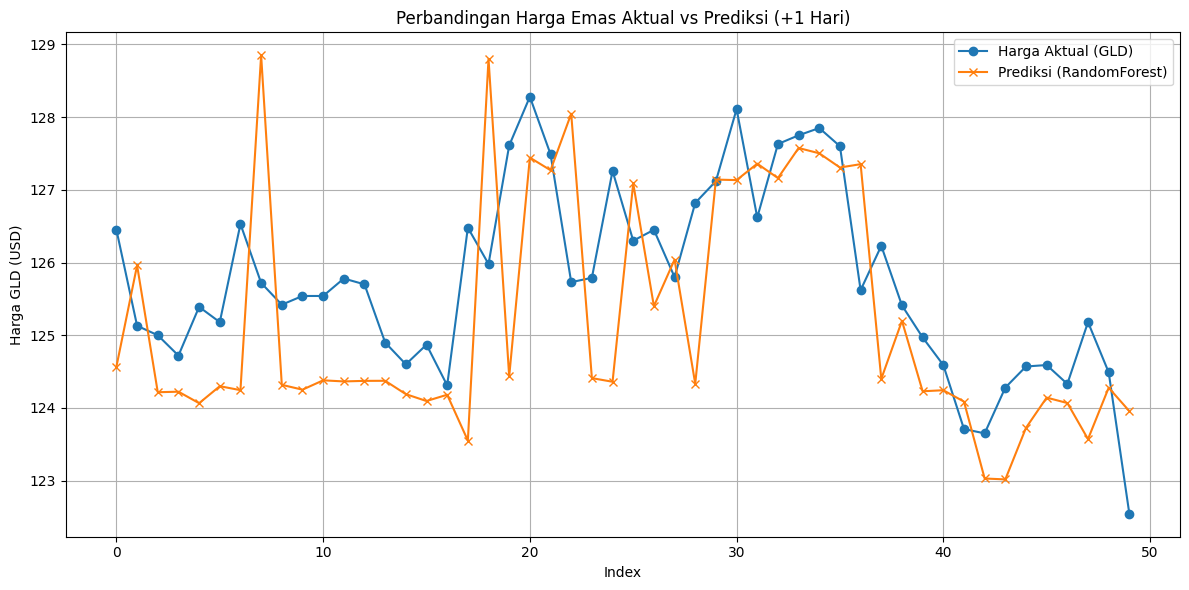

In [6]:
import matplotlib.pyplot as plt

# Prediksi dari model terbaik (misalnya XGBoost)
y_pred_plot = model_rf.predict(X_test)

# Plot 50 data terakhir
plt.figure(figsize=(12,6))
plt.plot(range(50), y_test[-50:].values, label='Harga Aktual (GLD)', marker='o')
plt.plot(range(50), y_pred_plot[-50:], label='Prediksi (RandomForest)', marker='x')
plt.title('Perbandingan Harga Emas Aktual vs Prediksi (+1 Hari)')
plt.xlabel('Index')
plt.ylabel('Harga GLD (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
# Hitung selisih antara harga aktual dan prediksi untuk Random Forest
df_results_rf = pd.DataFrame({'Actual': y_test, 'Prediction_RF': pred_rf})
df_results_rf['Difference_RF'] = df_results_rf['Prediction_RF'] - df_results_rf['Actual']
df_results_rf['Explanation_RF'] = df_results_rf['Difference_RF'].apply(lambda x: 'Lebih Tinggi' if x > 0 else ('Lebih Rendah' if x < 0 else 'Sama'))

print("\nSelisih Harga Aktual vs Prediksi (Random Forest):")
print(df_results_rf.head())

print(df_results_rf)



Selisih Harga Aktual vs Prediksi (Random Forest):
          Actual  Prediction_RF  Difference_RF Explanation_RF
1602  115.279999     116.034701       0.754702   Lebih Tinggi
1603  116.690002     114.845900      -1.844102   Lebih Rendah
1604  116.110001     115.890500      -0.219501   Lebih Rendah
1605  115.470001     116.031100       0.561099   Lebih Tinggi
1606  114.669998     114.959600       0.289602   Lebih Tinggi
          Actual  Prediction_RF  Difference_RF Explanation_RF
1602  115.279999     116.034701       0.754702   Lebih Tinggi
1603  116.690002     114.845900      -1.844102   Lebih Rendah
1604  116.110001     115.890500      -0.219501   Lebih Rendah
1605  115.470001     116.031100       0.561099   Lebih Tinggi
1606  114.669998     114.959600       0.289602   Lebih Tinggi
...          ...            ...            ...            ...
2284  124.589996     124.142001      -0.447995   Lebih Rendah
2285  124.330002     124.067401      -0.262601   Lebih Rendah
2286  125.180000   

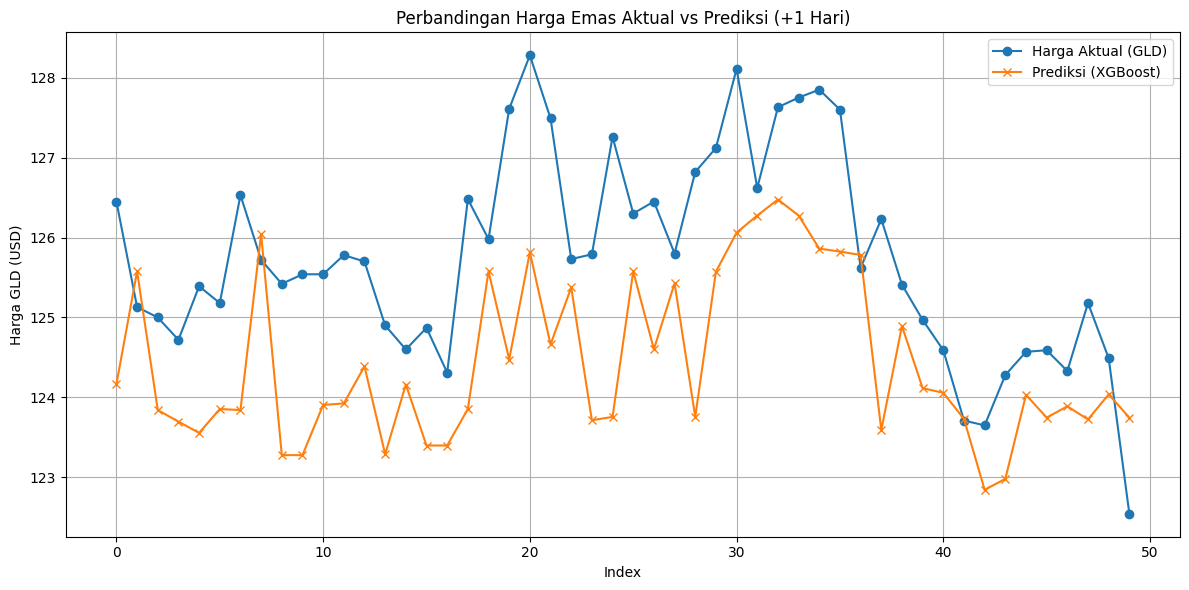

In [8]:
import matplotlib.pyplot as plt

# Prediksi dari model terbaik (misalnya XGBoost)
y_pred_plot = model_xgb.predict(X_test)

# Plot 50 data terakhir
plt.figure(figsize=(12,6))
plt.plot(range(50), y_test[-50:].values, label='Harga Aktual (GLD)', marker='o')
plt.plot(range(50), y_pred_plot[-50:], label='Prediksi (XGBoost)', marker='x')
plt.title('Perbandingan Harga Emas Aktual vs Prediksi (+1 Hari)')
plt.xlabel('Index')
plt.ylabel('Harga GLD (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Hitung selisih antara harga aktual dan prediksi untuk XGBoost
df_results_xgb = pd.DataFrame({'Actual': y_test, 'Prediction_XGB': pred_xgb})
df_results_xgb['Difference_XGB'] = df_results_xgb['Prediction_XGB'] - df_results_xgb['Actual']
df_results_xgb['Explanation_XGB'] = df_results_xgb['Difference_XGB'].apply(lambda x: 'Lebih Tinggi' if x > 0 else ('Lebih Rendah' if x < 0 else 'Sama'))

print("\nSelisih Harga Aktual vs Prediksi (XGBoost):")
print(df_results_xgb.head())

print(df_results_xgb)


Selisih Harga Aktual vs Prediksi (XGBoost):
          Actual  Prediction_XGB  Difference_XGB Explanation_XGB
1602  115.279999      114.308250       -0.971749    Lebih Rendah
1603  116.690002      114.587822       -2.102180    Lebih Rendah
1604  116.110001      116.153267        0.043266    Lebih Tinggi
1605  115.470001      116.014503        0.544502    Lebih Tinggi
1606  114.669998      114.055855       -0.614143    Lebih Rendah
          Actual  Prediction_XGB  Difference_XGB Explanation_XGB
1602  115.279999      114.308250       -0.971749    Lebih Rendah
1603  116.690002      114.587822       -2.102180    Lebih Rendah
1604  116.110001      116.153267        0.043266    Lebih Tinggi
1605  115.470001      116.014503        0.544502    Lebih Tinggi
1606  114.669998      114.055855       -0.614143    Lebih Rendah
...          ...             ...             ...             ...
2284  124.589996      123.747078       -0.842918    Lebih Rendah
2285  124.330002      123.888084       -0.441

In [15]:
import numpy as np
def evaluasi_model_train(model, X_train, y_train, nama_model="Model"):
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    print(f"Evaluasi {nama_model} pada data training:")
    print(f"  MSE  = {mse_train:.3f}")
    print(f"  RMSE = {rmse_train:.3f}")
    print(f"  R2   = {r2_train:.3f}\n")

print("\nEvaluasi pada data training:")
evaluasi_model_train(model_rf, X_train, y_train, "Random Forest")
evaluasi_model_train(model_xgb, X_train, y_train, "XGBoost")


Evaluasi pada data training:
Evaluasi Random Forest pada data training:
  MSE  = 0.467
  RMSE = 0.683
  R2   = 0.999

Evaluasi XGBoost pada data training:
  MSE  = 0.150
  RMSE = 0.388
  R2   = 1.000



In [11]:
def prediksi_harga_emas(model, input_fitur):
    """
    input_fitur: list/array fitur [SPX, USO, SLV, EUR/USD]
    """
    fitur = ['SPX', 'USO', 'SLV', 'EUR/USD', 'GLD', 'GLD_t-1']
    import pandas as pd

    input_df = pd.DataFrame([input_fitur], columns=fitur)
    pred = model.predict(input_df)[0]
    # Karena target adalah GLD esok hari, kita bandingkan dengan harga GLD hari ini
    current_price = input_fitur[-1]  # Namun, GLD hari ini tidak ada di fitur. Jadi perlu input harga emas hari ini juga!

    # Jadi kita ubah supaya user input harga emas hari ini sebagai parameter
    return pred

# Versi lengkap dengan keterangan naik/turun dan selisih:
def prediksi_harga_emas_lengkap(model, input_fitur, harga_emas_hari_ini):
    fitur = ['SPX', 'USO', 'SLV', 'EUR/USD', 'GLD', 'GLD_t-1']
    import pandas as pd

    input_df = pd.DataFrame([input_fitur], columns=fitur)
    pred = model.predict(input_df)[0]

    selisih = pred - harga_emas_hari_ini
    status = "Naik" if selisih > 0 else "Turun" if selisih < 0 else "Tetap"

    return pred, status, abs(selisih)

In [12]:
# Contoh input user: fitur hari ini
input_baru = [1409.130005, 75.25,15.52,1.466405, 86.550003,86.779999]  # SPX, USO, SLV, EUR/USD ,GLD hari ini, GLD kemarin
harga_emas_hari_ini =86.550003 # Harga emas hari ini (GLD)

# Prediksi Random Forest
prediksi, status, selisih = prediksi_harga_emas_lengkap(model_rf, input_baru, harga_emas_hari_ini)
print(f"Random Forest - Prediksi harga emas +1 hari: {prediksi:.2f} USD")
print(f"Status: {status} sebesar {selisih:.2f} USD dibanding harga saat ini {harga_emas_hari_ini:.2f} USD\n")

# Prediksi XGBoost
prediksi, status, selisih = prediksi_harga_emas_lengkap(model_xgb, input_baru, harga_emas_hari_ini)
print(f"XGBoost - Prediksi harga emas +1 hari: {prediksi:.2f} USD")
print(f"Status: {status} sebesar {selisih:.2f} USD dibanding harga saat ini {harga_emas_hari_ini:.2f} USD")

Random Forest - Prediksi harga emas +1 hari: 87.95 USD
Status: Naik sebesar 1.40 USD dibanding harga saat ini 86.55 USD

XGBoost - Prediksi harga emas +1 hari: 88.08 USD
Status: Naik sebesar 1.53 USD dibanding harga saat ini 86.55 USD
